In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from tensorflow.keras.utils import Sequence 
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Attention

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, Reshape
from tensorflow.keras.layers import MultiHeadAttention, Dense, GlobalAveragePooling2D, Add, Activation

from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, Permute, Multiply, Lambda
import tensorflow as tf



In [2]:
train_path =r'C:\Users\THOTA SIDDARTHA\Downloads\organised_maize\train'
train_path
val_path = r'C:\Users\THOTA SIDDARTHA\Downloads\organised_maize\val'
val_path
test_path = r'C:\Users\THOTA SIDDARTHA\Downloads\organised_maize\test'
test_path

'C:\\Users\\THOTA SIDDARTHA\\Downloads\\organised_maize\\test'

In [3]:
batch_size = 32
img_height = 224
img_width = 224

In [4]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,shear_range=0.15)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

Train_Image = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Val_Image = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Test_Image = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Print class indices
print("Class indices:", Train_Image.class_indices)

# Print number of samples in each subset
print("Number of training samples:", Train_Image.samples)
print("Number of validation samples:", Val_Image.samples)
print("Number of testing samples:", Test_Image.samples)

Found 2400 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Class indices: {'Bercak Daun': 0, 'Daun Sehat': 1, 'Hawar Daun': 2, 'Karat Daun': 3}
Number of training samples: 2400
Number of validation samples: 800
Number of testing samples: 800


In [5]:
train_class = Train_Image.num_classes
train_class

4

In [6]:
test_class = Test_Image.num_classes
test_class

4

In [7]:
EfficientNet = EfficientNetB4(weights='imagenet', include_top = False, input_shape = (224,224,3))


In [8]:
for i in EfficientNet.layers:
    i.trainable = False

In [9]:

def main_model(tl_model, class1):
    m_model = tl_model.output
    m_model = GlobalAveragePooling2D()(m_model)
    
    m_model = Dense(1024, activation='relu')(m_model)
    m_model = Dense(1024, activation='relu')(m_model)

    attention_output = Reshape((1, 1024))(m_model)  # Reshape for MultiHeadAttention
    attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(attention_output, attention_output)
    attention_output = Reshape((1024,))(attention_output)  # Reshape back to original shape
    
    combined_output = Add()([m_model, attention_output])
    combined_output = Activation("relu")(combined_output)
    
    combined_output = Dense(512, activation='relu')(combined_output)
    combined_output = Dense(class1, activation='softmax')(combined_output)
    
    return combined_output

In [10]:
combining_model = main_model(EfficientNet,train_class)


In [11]:
model = Model(inputs=EfficientNet.input, outputs=combining_model)

In [12]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

                                                                                                  
 block4e_add (Add)              (None, 14, 14, 112)  0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block4f_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block4e_add[0][0]']            
                                                                                                  
 block4f_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block4f_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4f_expand_activation (Act  (None, 14, 14, 672)  0          ['block4f_expand_bn[0][0]']      
 ivation) 

 ivation)                                                                                         
                                                                                                  
 block5b_dwconv (DepthwiseConv2  (None, 14, 14, 960)  24000      ['block5b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 14, 14, 960)  3840       ['block5b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5b_activation (Activation  (None, 14, 14, 960)  0          ['block5b_bn[0][0]']             
 )                                                                                                
          

 block5d_bn (BatchNormalization  (None, 14, 14, 960)  3840       ['block5d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5d_activation (Activation  (None, 14, 14, 960)  0          ['block5d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 960)         0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5d_se_squeeze[0][0]']     
          

                                                                                                  
 block5f_se_squeeze (GlobalAver  (None, 960)         0           ['block5f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5f_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5f_se_squeeze[0][0]']     
                                                                                                  
 block5f_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5f_se_reshape[0][0]']     
                                                                                                  
 block5f_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5f_se_reduce[0][0]']      
                                                                                                  
 block5f_s

                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 1632)   112608      ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_se_excite (Multiply)   (None, 7, 7, 1632)   0           ['block6b_activation[0][0]',     
                                                                  'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_project_conv (Conv2D)  (None, 7, 7, 272)    443904      ['block6b_se_excite[0][0]']      
                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 272)   1088        ['block6b_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6d_project_conv (Conv2D)  (None, 7, 7, 272)    443904      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 7, 7, 272)   1088        ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_drop (Dropout)         (None, 7, 7, 272)    0           ['block6d_project_bn[0][0]']     
                                                                                                  
 block6d_add (Add)              (None, 7, 7, 272)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
          

                                                                                                  
 block6f_drop (Dropout)         (None, 7, 7, 272)    0           ['block6f_project_bn[0][0]']     
                                                                                                  
 block6f_add (Add)              (None, 7, 7, 272)    0           ['block6f_drop[0][0]',           
                                                                  'block6e_add[0][0]']            
                                                                                                  
 block6g_expand_conv (Conv2D)   (None, 7, 7, 1632)   443904      ['block6f_add[0][0]']            
                                                                                                  
 block6g_expand_bn (BatchNormal  (None, 7, 7, 1632)  6528        ['block6g_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1632)   443904      ['block6h_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1632)  6528        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1632)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 7, 7, 1632)  14688       ['block7a_expand_activation[0][0]
 D)       

 dense (Dense)                  (None, 1024)         1836032     ['global_average_pooling2d[0][0]'
                                                                 ]                                
                                                                                                  
 dense_1 (Dense)                (None, 1024)         1049600     ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 512)          524800      ['dense_1[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 4)            2052        ['dense_2[0][0]']                
                                                                                                  
Total params: 21,086,307
Trainable params: 3,412,484
Non-trainable params: 17,673,823
_______________________

In [13]:
history = model.fit(Train_Image,steps_per_epoch=Train_Image.samples // batch_size, epochs=50,validation_data=Val_Image,validation_steps=Val_Image.samples // batch_size)

Epoch 1/50
75/75 [==============================] - 315s 4s/step - loss: 0.4089 - accuracy: 0.8450 - val_loss: 0.3208 - val_accuracy: 0.8700
Epoch 2/50
75/75 [==============================] - 431s 6s/step - loss: 0.1969 - accuracy: 0.9300 - val_loss: 0.2157 - val_accuracy: 0.9225
Epoch 3/50
75/75 [==============================] - 477s 6s/step - loss: 0.1526 - accuracy: 0.9467 - val_loss: 0.1748 - val_accuracy: 0.9250
Epoch 4/50
75/75 [==============================] - 497s 7s/step - loss: 0.1587 - accuracy: 0.9413 - val_loss: 0.1620 - val_accuracy: 0.9287
Epoch 5/50
75/75 [==============================] - 559s 7s/step - loss: 0.1485 - accuracy: 0.9463 - val_loss: 0.1490 - val_accuracy: 0.9400
Epoch 6/50
75/75 [==============================] - 542s 7s/step - loss: 0.1291 - accuracy: 0.9538 - val_loss: 0.1636 - val_accuracy: 0.9438
Epoch 7/50
75/75 [==============================] - 772s 10s/step - loss: 0.1615 - accuracy: 0.9529 - val_loss: 0.1703 - val_accuracy: 0.9450
Epoch 8/50
7

In [14]:
with open('maize_efficientnet50_secondlayer.pkl', 'wb') as f:
    pickle.dump(model, f)

In [15]:
Test_score = model.evaluate(Test_Image,steps = len(Test_Image))
Test_score

25/25 [==============================] - 119s 5s/step - loss: 0.1795 - accuracy: 0.9513


[0.17948301136493683, 0.9512500166893005]

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools 


target_names = []
for key in Train_Image.class_indices:
    target_names.append(key)

In [17]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

25/25 [==============================] - 121s 5s/step
Confusion Matrix
Confusion matrix, without normalization


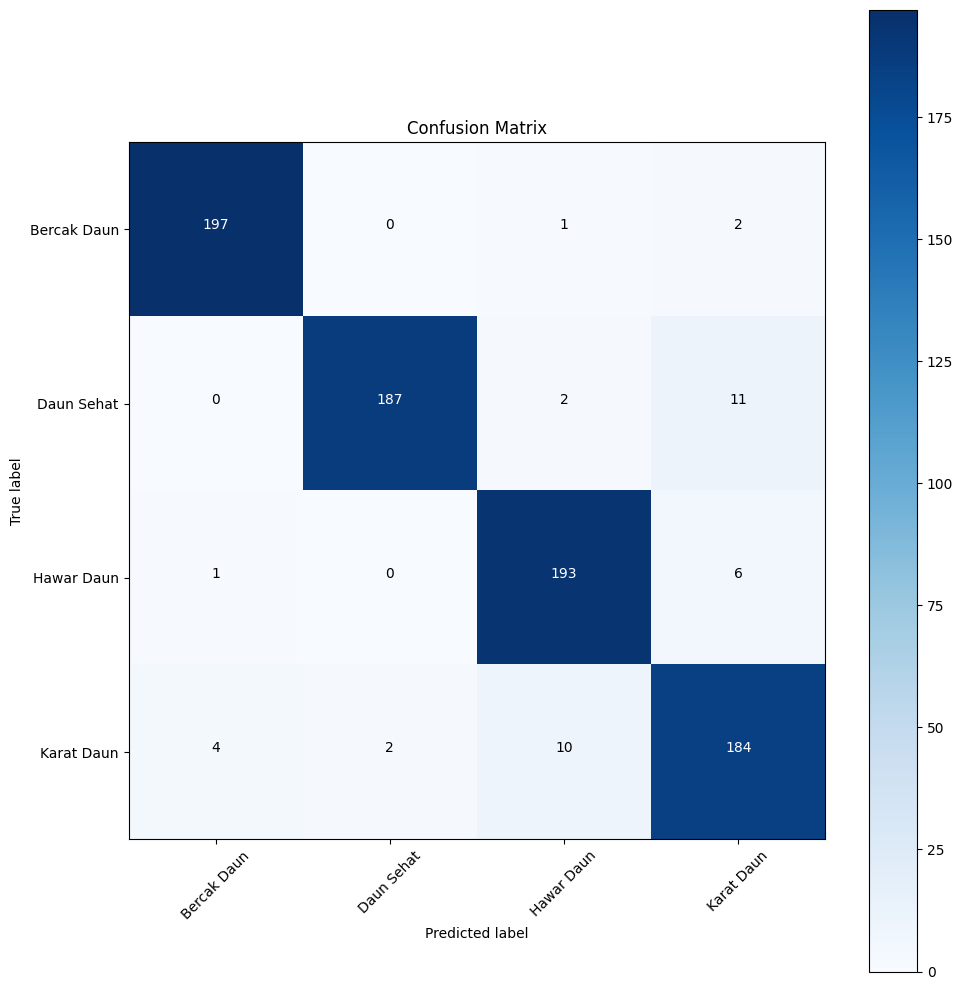

In [18]:
#Confution Matrix and Classification Report
Y_pred_Model = model.predict(Test_Image)
Y_pred_Model = np.argmax(Y_pred_Model, axis=-1)
print('Confusion Matrix') 
CM_Model=confusion_matrix(Test_Image.classes, Y_pred_Model)

plot_confusion_matrix(CM_Model, target_names, title='Confusion Matrix')


In [19]:
print('Classification Report')
print(classification_report(Test_Image.classes, Y_pred_Model, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

 Bercak Daun       0.98      0.98      0.98       200
  Daun Sehat       0.99      0.94      0.96       200
  Hawar Daun       0.94      0.96      0.95       200
  Karat Daun       0.91      0.92      0.91       200

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



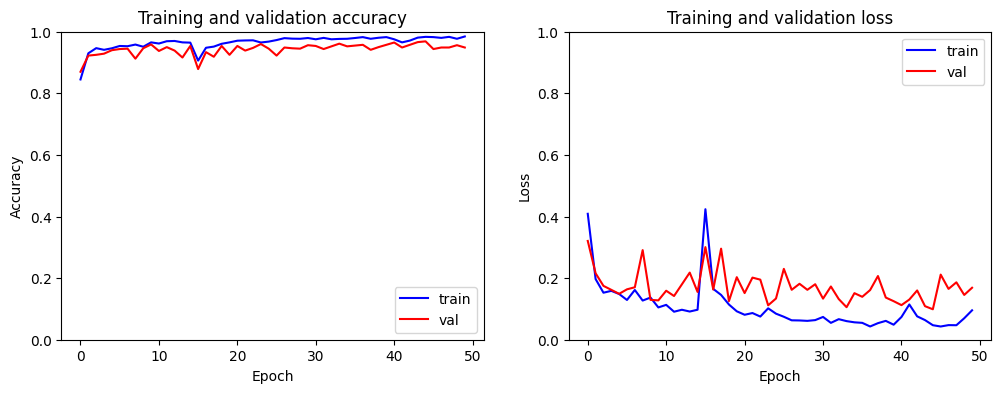

In [20]:
import matplotlib.pyplot as plt

Train_accuracy = history.history['accuracy']
Val_accuracy = history.history['val_accuracy']
Train_loss = history.history['loss']
Val_loss = history.history['val_loss']

epochs = range(len(Train_accuracy))
plt.figure(figsize=(12, 4))

# Plotting the accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, Train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, Val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Setting y-axis range
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1, 2, 2)
plt.plot(epochs, Train_loss, 'b', label='Training loss')
plt.plot(epochs, Val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Setting y-axis range
plt.legend(['train', 'val'], loc='upper right')

plt.show()
